In [1]:
# Standard code libraries
import os
import platform
import glob

import numpy as np
import scipy
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
from resurfemg.config.config import Config
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_classes.data_classes import (
    TimeSeriesGroup, VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Root directory for test data
config = Config()
root_patient_data_directory = \
    config.get_directory('test_data')

if platform.system() == 'Windows':
    path_sep = "\\"
else:
    path_sep = '/'

# Identify all recordings available for the selected patient/measurement_date
emg_pattern = os.path.join(root_patient_data_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'vent' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

emg_file_chosen = emg_files[0]
vent_file_chosen = vent_files[0]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\emg_data_synth_pocc.Poly5 
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\vent_data_synth_pocc.Poly5


In [3]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

# Default settings for window of interest including the end-expiratory occlusion
# manoeuvres (Pocc)
t_start_default = t_vent[-1]-60
t_end_default = t_vent[-1]-5

Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\emg_data_synth_pocc.Poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\vent_data_synth_pocc.Poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [4]:
emg_timeseries = EmgDataGroup(y_emg, fs=fs_emg, labels=['ECG', 'EMGdi'], units=3*['uV'])
emg_timeseries.filter()
emg_timeseries.gating()
# emg_timeseries.envelope(signal_type='clean')
emg_timeseries.envelope(env_type='arv', signal_type='clean')
emg_timeseries.baseline()

Auto-detected ECG channel from labels.


In [5]:
vent_timeseries = VentilatorDataGroup(y_vent, fs=fs_vent, labels=['Paw', 'F', 'Vvent'], units=['cmH2O', 'L/s', 'L'])
vent_timeseries.baseline(channel_idxs=[0], signal_type='raw')

Auto-detected Paw channel from labels.
Auto-detected Flow channel from labels.
Auto-detected Volume channel from labels.


(370.0, 410.0)

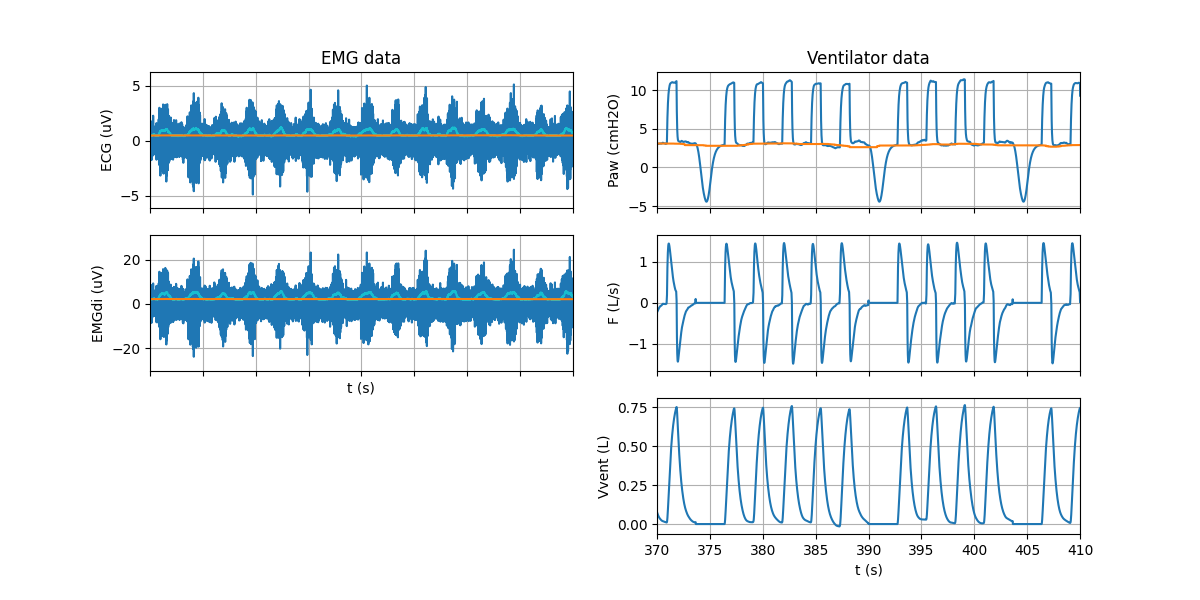

In [6]:
# Plot the raw data with the envelope
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg = axis[:2, 0]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.plot_full(axes_emg, signal_type='clean', baseline_bool=False)
emg_timeseries.plot_full(axes_emg, signal_type='env', colors=colors)
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

axis[-1, 0].axis('off')

axes_vent[-1].set_xlim([370, 410])

In [7]:
# Find occlusion pressures
vent_timeseries.peep
vent_timeseries.find_occluded_breaths(
    vent_timeseries.p_aw_idx, start_idx=360*vent_timeseries.fs)

paw = vent_timeseries.channels[vent_timeseries.p_aw_idx]
paw.peaks['Pocc'].detect_on_offset(baseline=paw.y_baseline)

paw.peaks['Pocc'].peak_df['peak_idx']/paw.fs

# Find supported breath pressures
v_vent = vent_timeseries.channels[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks()

paw.peaks['Pocc'].peak_df['peak_idx']/paw.fs
# paw.peaks['ventilator_breaths'].peak_df['peak_idx']
# v_vent.peaks['ventilator_breaths'].peak_df['peak_idx']

0    374.65
1    391.01
2    404.65
Name: peak_idx, dtype: float64

In [8]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di = emg_timeseries.channels[1]
emg_di.detect_emg_breaths(peak_set_name='breaths')
emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)

# Link ventilator Pocc peaks to EMG breaths
t_pocc_peaks_vent = paw.peaks['Pocc'].peak_df['peak_idx'].to_numpy() / paw.fs
emg_di.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_pocc_peaks_vent,
    linked_peak_set_name='Pocc',
)
emg_di.peaks['Pocc'].peak_df['start_idx']/emg_di.fs


0    373.281250
1    389.674805
2    403.266113
Name: start_idx, dtype: float64

(370.0, 410.0, 0.0, 1.0)

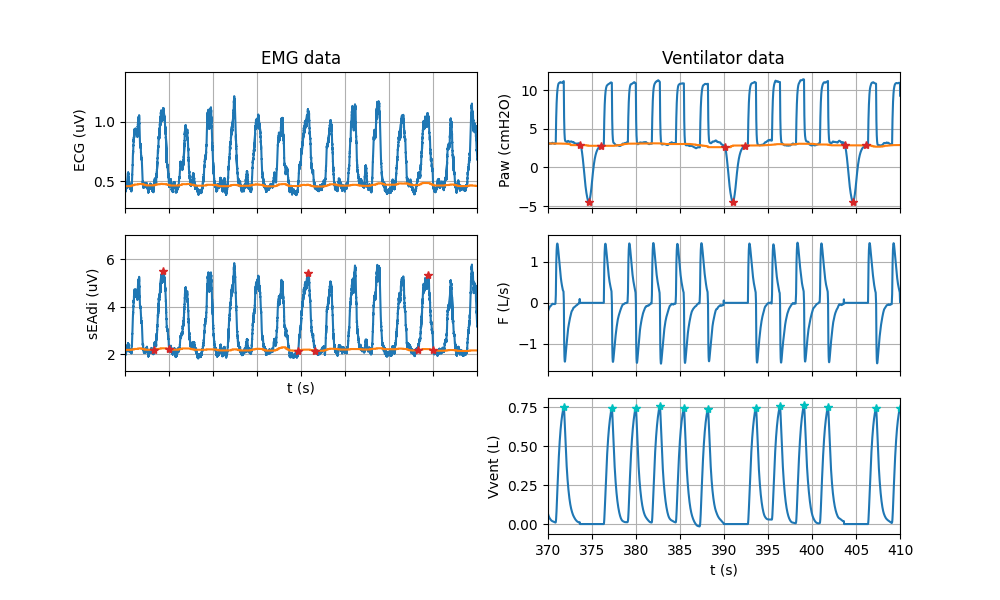

In [9]:
# Plot the identified Pocc peaks in Paw and sEAdi
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:-1, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
# emg_timeseries.plot_full(axes_emg, signal_type='clean', baseline_bool=False)
# emg_timeseries.plot_full(axes_emg, signal_type='env', colors=colors)
emg_timeseries.plot_full(axes_emg, signal_type='env')
emg_di.plot_markers(peak_set_name='Pocc', axes=axes_emg[1])
axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
paw.plot_markers(peak_set_name='Pocc', axes=axes_vent[0])
v_vent.plot_markers(peak_set_name='ventilator_breaths',
                    axes=axes_vent[2], colors='c')

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([370, 410])

axis[-1, 0].axis('off')

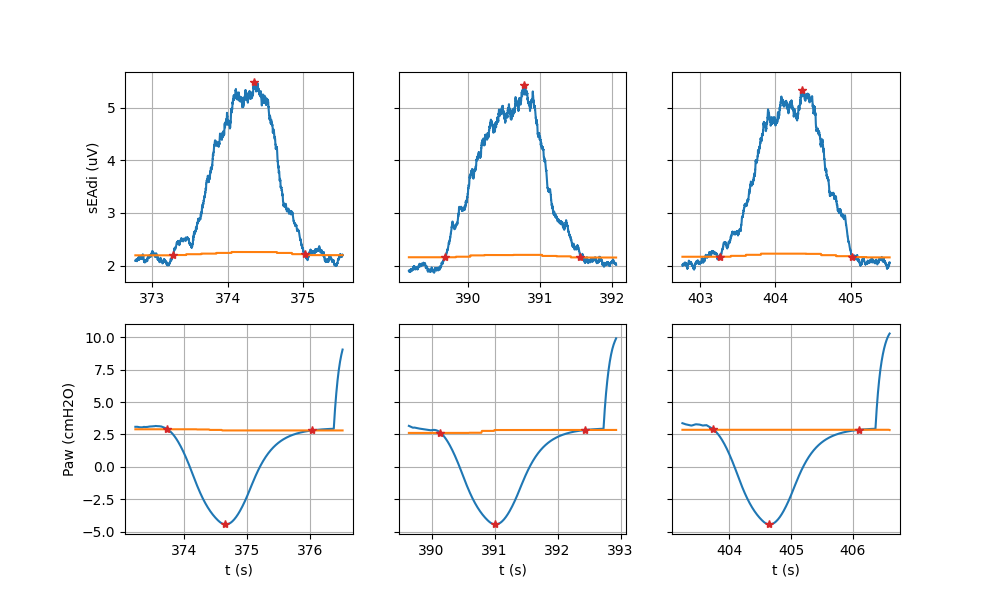

In [10]:
# Plot the individual peaks
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
paw.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
paw.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

In [16]:
# Calculate ETPdi and PTPocc
emg_di.calculate_time_products(
    peak_set_name='Pocc', parameter_name='ETPdi')

paw.calculate_time_products(
    peak_set_name='Pocc', 
    aub_reference_signal=paw.y_baseline,
    parameter_name='PTPocc')

emg_di.peaks['Pocc'].peak_df, paw.peaks['Pocc'].peak_df

(   peak_idx  start_idx  end_idx  valid       AUB    ETPdi
 0    766676     764480   768039   True  0.737245  3.59566
 1    800300     798054   801907   True  0.629283  3.78081
 2    828113     825889   829475   True  0.543593  3.55627,
    peak_idx  start_idx  end_idx  valid       AUB    PTPocc
 0     37465      37372    37602   True  0.629043  7.967947
 1     39101      39014    39244   True  0.612831  7.816193
 2     40465      40374    40611   True  0.503030  7.895531)

In [38]:
emg_di.test_emg_quality('Pocc')
emg_di.peaks['Pocc'].peak_df

Test values:
   peak_idx       snr        aub
0    766676  2.468262  20.503761
1    800300  2.484715  16.644122
2    828113  2.426261  15.285478
Test outcomes:
   peak_idx  baseline_detection  interpeak_distance   snr   aub
0    766676                True                True  True  True
1    800300                True                True  True  True
2    828113                True                True  True  True


,peak_idx,start_idx,end_idx,valid,AUB,ETPdi
0,766676,764480,768039,True,0.737245,3.59566
1,800300,798054,801907,True,0.629283,3.78081
2,828113,825889,829475,True,0.543593,3.55627


In [36]:
parameter_names = {
    'time_product': 'PTPocc'
}
paw.test_pocc_quality('Pocc', parameter_names=parameter_names)
paw.peaks['Pocc'].peak_df

Test values:
   peak_idx  dP_up_10  dP_up_90  dP_up_90_norm
0     37465  0.009708  0.110633       0.039193
1     39101  0.008363  0.109885       0.039304
2     40465  0.007633  0.109652       0.039023
Test outcomes:
   peak_idx  baseline_detection  consecutive_poccs  pocc_upslope
0     37465                True               True          True
1     39101                True               True          True
2     40465                True               True          True


,peak_idx,start_idx,end_idx,valid,AUB,PTPocc
0,37465,37372,37602,True,0.629043,7.967947
1,39101,39014,39244,True,0.612831,7.816193
2,40465,40374,40611,True,0.503030,7.895531
